In [1]:
import functools

import matplotlib
from matplotlib import pyplot
import numpy as np

import sys
sys.path.append("..")
from hiora_cartpole import features
from hiora_cartpole import fourier_fa
from hiora_cartpole import easytile_fa
from hiora_cartpole import offswitch_hfa
from hiora_cartpole import linfa
from hiora_cartpole import driver
from hiora_cartpole import interruptibility

import gym_ext.tools as gym_tools

import gym
import gym.wrappers

/home/erle/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
cartpole = gym.make('OffSwitchCartpole-v0')
clipped_high = np.array([2.5, 3.6, 0.27, 3.7])
clipped_low  = -clipped_high
state_ranges = np.array([clipped_low, clipped_high])

[2016-09-26 14:52:17,091] Making new env: OffSwitchCartpole-v0


In [3]:
env = gym.wrappers.TraceRecordingWrapper(cartpole, "/tmp/cartpole-recordings")

In [4]:
four_n_weights, four_feature_vec \
    = fourier_fa.make_feature_vec(state_ranges,
                                  n_acts=2,
                                  order=3)

ofour_n_weights, ofour_feature_vec \
    = offswitch_hfa.make_feature_vec(four_feature_vec, four_n_weights)

    
skip_offswitch_clip = functools.partial(
                          gym_tools.apply_to_snd, 
                          functools.partial(gym_tools.warning_clip_obs, ranges=state_ranges))    

def make_interruptable_experience():
    return linfa.init(lmbda=0.9,
                        init_alpha=0.001,
                        epsi=0.1,
                        feature_vec=ofour_feature_vec,
                        n_weights=ofour_n_weights,
                        act_space=env.action_space,
                        theta=None,
                        is_use_alpha_bounds=True,
                        map_obs=skip_offswitch_clip)

fexperience = make_interruptable_experience()

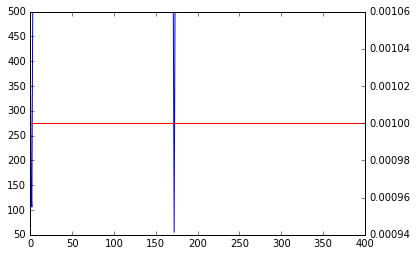

In [30]:
fexperience, steps_per_episode, alpha_per_episode \
    = driver.train(env, linfa, fexperience, n_episodes=400, max_steps=500, is_render=False)
# Credits: http://matplotlib.org/examples/api/two_scales.html
fig, ax1 = pyplot.subplots()
ax1.plot(steps_per_episode, color='b')
ax2 = ax1.twinx()
ax2.plot(alpha_per_episode, color='r')
pyplot.show()

In [39]:
steps_per_episode = driver.exec_greedy(env, fexperience, n_episodes=7, max_steps=600, is_render=True)

In [22]:
env.num_crosses

[0.0, 4.0]

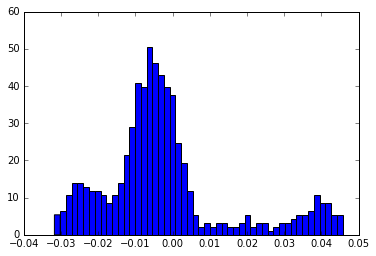

In [41]:
positions = np.array([o[1][0] for o in env.observations])
pyplot.hist(positions, bins=50, normed=True)
pyplot.show()

## Average bias of Sarsa on OffSwitchCartpole

In [ ]:
def make_OffSwitchCartpole():
    return gym.make("OffSwitchCartpole-v0")

rewards_per_episode, lefts_rights = \
    interruptibility.run_rewards_lefts_rights(
        make_OffSwitchCartpole,
        make_interruptable_experience,
        n_procs=4,
        n_trainings=4,
        n_episodes=200,
        max_steps=500)

[103415 220956]


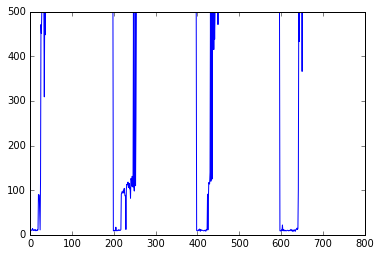

In [8]:
print lefts_rights
pyplot.plot(rewards_per_episode)
pyplot.show()